### MCMC Metropolis-Hastings

In [1]:
import sys
import itertools

from tqdm import tqdm

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

sys.path.append("..")
import helper.helper as h

Generate a random $A$, with $\texttt{num_edges}$, where the edge weights are between $0.5$ and $1.0$. The matrix $A$ is lower triangular, but allows for entries to be non-zero on the diagonal.

In [23]:
def generate_A(n, num_edges):
    edges = np.array([0.0] * (int(n * (n + 1) / 2) - num_edges) + [1.0] * num_edges)
    
    edges[edges > 0] = (2 * np.random.randint(0, 2, size=(num_edges)) - 1) * np.random.uniform(0.5, 2.5, num_edges)
    np.random.shuffle(edges)
    
    A = np.zeros((n, n))
    A[np.tril_indices(n)] = edges
    
    for i, elem in enumerate(np.diag(A)):
        if np.abs(elem) > 1:
            A[i][i] = np.random.uniform(low = 0.9, high = 0.9)
        
    return A

Generate data according to a VAR(1) model with $P^TAP$ as matrix. $\texttt{n}$-dimensional, $\texttt{s}$ non-zero entries, $\texttt{T}$ samples.

A:
[[-0.98  0.    0.  ]
 [ 2.18  0.9   0.  ]
 [-2.21 -2.46  0.9 ]]

P:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]].

W:
[[-0.98  0.    0.  ]
 [ 2.18  0.9   0.  ]
 [-2.21 -2.46  0.9 ]].


W_OLS: is a DAG: False:
[[-1.  -0.  -0.1]
 [ 2.2  0.9  0.1]
 [-2.1 -2.6  0.8]].

W_OLS_LT: is a DAG: True:
[[-1.01  0.    0.  ]
 [ 2.21  0.89  0.  ]
 [-2.15 -2.62  0.87]].


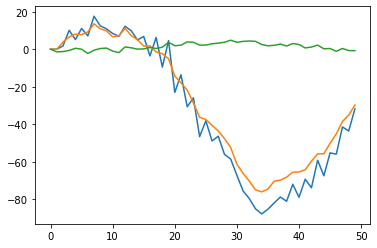

In [53]:
## Number of dimensions, number of edges, number of samples
T, n, s = 50, 3, 6

## Coefficient matrix
A_true = generate_A(n, s)

## True permutation
P_true = np.random.permutation(np.identity(n))

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.\n")

print(f"W:\n{np.round(P_true.T @ A_true @ P_true, 2)}.\n\n")

print(f"W_OLS: is a DAG: {is_dag(ols_W_2(X))}:\n{np.round(ols_W_2(X), 1)}.\n")

print(f"W_OLS_LT: is a DAG: {is_dag(ols_W(X, P_true))[0]}:\n{np.round(ols_W(X, P_true), 2)}.")

Given data $\mathbf{X}$ and a permutation $P$, find the least squares solution $\hat{A}_{OLS}$, where $\hat{A}_{OLS}$ is lower triangular and $$W = P^TAP.$$

So, for $X_{\pi(1)}$, we can only use that variable. For $X_{\pi(2)}$, we can only use $X_{\pi(1)}$ and that variable, etc., until $X_{\pi(n)}$, where we can use all variables. 

Let $\mathbf{X}_{\pi}$ be the data matrix $\mathbf{X}$ that has been permuted by a matrix $P$. 

We seek to solve the problem

$$W_i = \arg \min \lVert \mathbf{X}_{\pi, i} - X_{\pi, i:} \rVert_2^2$$

In [6]:
def ols_W(X, P, LT = False):
    # translate X
    x = X @ P.T
    
    # get regressor and varibles
    y = x[1:]
    x = x[:-1]

    W_hat = np.array(np.zeros(n)).T

    # get parameters
    for i in range(n):
        est = sm.OLS(y[:, i], x[:, i:]).fit()   
        W_hat = np.vstack((W_hat, np.append(np.zeros(i), est.params).T))
    
    if LT:
        return W_hat[1:].T
    
    return P.T @ W_hat[1:].T @ P

def ols_W_2(X):
    # get regressor and varibles
    y = X[1:]
    x = X[:-1]

    W_hat = np.array([])

    # get parameters
    for i in range(n):
        est = sm.OLS(y[:, i], x).fit()
        W_hat = np.append(W_hat, est.params)

    W_hat = W_hat.reshape((n, n)).T
    
    return W_hat

As we have seen in Section, relaxing the search space from the set of permutation matrices to the set of doubly stochastic matrices created numerous issues. Although the search space is now continuous rather than combinatorial, the presence of singular or close to singular doubly stochastic matrices makes it difficult to retrieve a local optimum ($A, P$) such that $P$ is ``close" to a permutation matrix. This section takes one step back and tries a novel approach to find a suitable permutation matrix $P$. 

The approach that we will investigate in this section is a so-called $\textit{Markov Chain Monte Carlo}$ (MCMC) method.

\begin{equation}
q_{P, P^{\prime}}=\operatorname{Pr}\left(s_{i+1}=P^{\prime} \mid s_{i}=P\right)= \begin{cases}0 & \text { if } P^{\prime} \text { is not within one move from } P \\ \frac{1}{n_{P}} & \text { otherwise }\end{cases}
\end{equation}

Here, we define ``one move" as the interchanging of two variables $X_i$ and $X_j$. This is done by interchanging the $i$th row and the $j$th row or equivalently, interchanging the $i$th row and the $j$th column. 

Given a permutation matrix on $n$ variables, there are a total of $n \choose{2}$ possible moves. Hence, the possible number of valid moves does not depend on the permutation matrix $P$. 

In [7]:
def sample_next_P(P):  
    # get copy
    P_return = P.copy()
    
    # get the two rows to swap
    i, j = np.random.choice(n, 2, replace = False)
    
    # swap row i and row j
    P_return[[i, j]] = P_return[[j, i]]
    
    # return new sample
    return P_return

Let us now define the probability of acceptace $\alpha_{P, P^\prime}$ as

\begin{equation}
\alpha_{P, P^{\prime}}= \begin{cases}\min \left\{\frac{\mathcal{L}\left(\mathbf{X} \mid P^{\prime}\right) } {\mathcal{L}(\mathbf{X} \mid P)}, 1\right\} & \text { if } \mathcal{L}(\mathbf{x} \mid P)  >0 \\ 1 & \text { otherwise }\end{cases}
\end{equation}

Loss function. Stack all data into $\mathbf{X}$.

The loss function is
$$l(A, P; \mathbf{X}) = \frac{1}{T-1}\left\lVert\mathbf{X}_{[1:T]} - \mathbf{X}_{[0:T-1]} P^T A P\right\rVert_F^2$$
Its gradient is
$$\nabla l(A, P; \mathbf{X}) = -\frac{2}{T-1}\left(\mathbf{X}_{[0:T-1]} P^T\right)^T \left\lVert\mathbf{X}_{[1:T]} - \mathbf{X}_{[0:T-1]} P^T A P\right\rVert_F P^T$$

In [8]:
def loss_W(W):
    # Get prediction data
    M = X @ W
    
    # Remove X[0] and XW[last]
    R = X[1:] - M[:-1]
    
    # Frobenius norm squared loss
    loss = 1 / X[1:].shape[0] * (R ** 2).sum()
    
    # Return loss
    return loss

Likelihood of a permutation matrix $P$. In other words, the "score" we assign to a permutation matrix $P$. We define
$$\mathcal{L}(P; \mathbf{X}) = \arg_{A \in LT} \min l(A, P; \mathbf{X})$$

In [9]:
def get_likelihood(P):  
    # get loss    
    return loss_W(ols_W(X, P))

In [57]:
def mcmc(max_it, verbose, P = np.identity(n), factor = 1.0):
    
    # initial value
    likelihood_P = get_likelihood(P)

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_iteration = [0]

    # transitions
    transitions = 0
    
    for i in tqdm(range(max_it)):   
        # sample next P
        P_prime = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P_prime = get_likelihood(P_prime)
        alpha = min(likelihood_P / likelihood_P_prime, 1)
    
        # print results
        if verbose:
            print(f"Iteration {i+1}.\n")
            print(f"Old P:\n{P}\nLikelihood: {round(likelihood_P, 2)}\n\nNew P:\n{P_prime}\nLikelihood: {round(likelihood_P_prime, 2)}.")
            print(f"\nAcceptance probability: {round(alpha, 3)}.")
    
        # prepare for next iteration
        if np.random.rand() <= alpha * factor:
            transitions += 1
            P, likelihood_P = P_prime, likelihood_P_prime
        
            # save best
            if likelihood_P < L_best:
                L_best = likelihood_P
                P_best = P
                
        results_likelihood.append(likelihood_P)
        results_iteration.append(i + 1)
    
    print(transitions)
    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, results_iteration, results_likelihood

In [11]:
P_best, _, _ = mcmc(1000, False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.99it/s]

987
Best permutation:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1

### Verifications.
The permutation matrix $P$ should be compatible with $P_{true}$. In other words, there are no edges in $P_{true}$ that would "not be allowed" in $P$, because the we would have an arc pointing "back".

In [49]:
# verify whether the permutation is campatible
check = P_best @ P_true.T @ A_true @ P_true @ P_best.T
check_tril = np.tril(check)
print(len(check_tril[check_tril != 0]) == s)

True


Is the matrix $P^T A P$ equal or comparable to $P_{true}^T A_{true} P_{true}$? We check this. We also apply thresholding, note that cherrypicking this threshold should be avoided as it can give false hope, we do not know $W_{true}$.

In [50]:
thresh = 0.25
check_thresh = ols_W(X, P_best)
check_thresh[np.abs(check_thresh) < thresh] = 0
print(f"Thresholded W:\n{np.round(check_thresh, 2)}")
print(np.round(check_thresh[check_thresh.nonzero()], 2))

Thresholded W:
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   2.17]
 ...
 [0.   0.   0.   ... 0.   0.   0.51]
 [0.   0.   0.   ... 0.   0.9  0.  ]
 [0.   0.   0.   ... 0.   0.   0.9 ]]
[ 1.83  2.46 -2.22 -1.32  1.11 -1.63  2.3   1.8   2.14  2.17 -0.6   1.67
 -1.59  1.51 -2.27  1.76  1.69 -1.58  1.08  1.59  2.13 -1.14 -2.2   1.67
 -2.07  1.44 -2.29  2.06  1.33  1.6  -0.51  1.54  1.62 -2.27  1.24  0.67
 -2.03  1.25  1.58  0.53  0.53  0.92 -0.92  0.82  2.01 -2.27  1.65 -1.97
  1.6   1.88 -1.57 -2.04  0.71 -0.62  2.25 -1.17 -1.66 -1.09 -0.91 -2.22
 -2.18  0.78 -2.02  0.68 -1.28  0.74  0.85 -1.74  1.81 -2.43 -2.32 -1.06
 -1.79 -0.92  1.53  0.82  1.8  -1.11 -0.78  2.34 -0.72  1.17 -1.92 -1.67
  1.83  1.08 -1.96 -2.15 -1.33 -1.83 -0.58 -2.19  1.37 -0.77  2.16  0.95
  0.59  1.48 -1.41 -1.37  0.55  1.99 -2.46  0.86  1.66  0.5   1.27 -1.81
  1.69 -0.83  1.63  1.59 -1.74  0.9   1.51 -1.49 -1.92 -1.92 -1.65 -0.79
 -0.88 -2.15 -1.48  1.8  -1

In [51]:
truth = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(truth, 2)}.")
print(np.round(truth[truth.nonzero()], 2))

True W:
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   2.17]
 ...
 [0.   0.   0.   ... 0.   0.   0.51]
 [0.   0.   0.   ... 0.   0.9  0.  ]
 [0.   0.   0.   ... 0.   0.   0.9 ]].
[ 1.82  2.43 -2.22 -1.31  1.12 -1.62  2.31  1.8   2.14  2.17 -0.61  1.68
 -1.57  1.59 -2.21  1.76  1.71 -1.59  1.12  1.69  2.07 -1.15 -2.21  1.71
 -2.09  1.45 -2.24  2.06  1.33  1.64 -0.52  1.54  1.63 -2.27  1.22  0.65
 -2.02  1.23  1.57  0.53  0.54  0.92 -0.91  0.8   2.08 -2.24  1.61 -2.03
  1.63  1.84 -1.61 -2.02  0.68 -0.64  2.24 -1.17 -1.66 -1.12 -0.88 -2.23
 -2.19  0.77 -2.06  0.66 -1.28  0.71  0.9  -1.78  1.87 -2.42 -2.31 -1.11
 -1.82 -0.93  1.57  0.69  1.77 -1.11 -0.83  2.26 -0.72  1.16 -1.93 -1.67
  1.83  1.08 -1.95 -2.16 -1.33 -1.83 -0.58 -2.2   1.36 -0.76  2.16  0.97
  0.59  1.49 -1.39 -1.36  0.55  2.01 -2.47  0.88  1.62  0.5   1.27 -1.81
  1.69 -0.83  1.64  1.59 -1.74  0.9   1.51 -1.49 -1.92 -1.93 -1.67 -0.74
 -0.88 -2.17 -1.49  1.87 -1.74  0

Statistics
- True Positive Rate (TPR): Percentage of edges in W_true that were in W
- True Negative Rate (TNR): Percentage of edges that were *not* in W_true that were also n*not* in W
- Accuracy: Percentage of correctly estimated entries of W
- False Detection Rate (FDR): Percentage of edges in W_est that were *not* in W_true

In [52]:
truth_bin = truth.copy()
truth_bin[truth_bin != 0] = 1

check_thresh_bin = check_thresh.copy()
check_thresh_bin[check_thresh_bin != 0] = 1

true_edges = np.flatnonzero(truth)
pred_edges = np.flatnonzero(check_thresh)
tpr = len(np.intersect1d(pred_edges, true_edges, assume_unique=True)) / len(true_edges)

true_non_edges = np.flatnonzero(truth_bin - 1)
pred_non_edges = np.flatnonzero(check_thresh_bin - 1)
tnr = len(np.intersect1d(pred_non_edges, true_non_edges, assume_unique=True)) / len(true_non_edges)

pred_false_edges = np.setdiff1d(pred_edges, true_edges)
fpr = len(pred_false_edges) / len(pred_edges)

accuracy = len(truth_bin[truth_bin == check_thresh_bin]) / len(truth_bin.flatten())
print(f"True Positive Rate: {round(tpr, 3)}.\nTrue Negative Rate: {round(tnr, 3)}.\nFalse Prediction Rate: {round(fpr, 3)}\nAccuracy: {round(accuracy, 3)}.")

True Positive Rate: 1.0.
True Negative Rate: 1.0.
False Prediction Rate: 0.0
Accuracy: 1.0.


# Initialization for $P_0$
What value shoudl $P_0$ be? Could be the identity, but that could be very far off from the actual permutation. A better strategy is to e.g. perform ordinary least squares on the VAR(1) model to estimate $\hat{W}$. Note that $\hat{W}$ is not necessarily the WAM of a DAG. To massage $\hat{W}$ into the WAM of a DAG, we iteratively set the smallest element (in absolute value) $w_{ij}$ to zero, until we have a WAM compatible with a DAG.

We first do OLS to get $A$

In [16]:
def is_dag(W):
    # remove diagonal entries
    np.fill_diagonal(W, 0)
    
    order, old_order = [], list(range(n))
    
    # for the number of elements
    for i in range(n):
        
        # find a row that contains only zeros
        for j in range(n - i):
            # if we find a zero row (excl. diags)
            if not W[j].any() != 0:
                
                # remove this row and column
                W = np.delete(W, j, 0)
                W = np.delete(W, j, 1)
            
                order.append(old_order[j])
                old_order.remove(old_order[j])
                
                # go to next variable
                break
        
            # if no zero row exist stop
            elif i == n - 1:
                return False
            
    return True, order

In [17]:
def permute(order):
    P = np.zeros((n, n))
    for idx, elem in enumerate(order):
        P[idx][elem] = 1
    return P

In [18]:
def get_P_0(X):
    W_hat = ols_W_2(X)
    
    while not is_dag(W_hat):
        # Get the indices of minimum element in numpy array
        # little trickery to skip zero values
        W_hat[W_hat == 0] = np.inf
        min_loc = np.where(np.abs(W_hat) == np.amin(np.abs(W_hat)))
        W_hat[W_hat == np.inf] = 0

        # set minimum value to zero
        W_hat[min_loc] = 0

    return permute(is_dag(W_hat)[1])

P_0 = get_P_0(X)
P_best, iter_list, likelihood_list = mcmc(1000, False, np.identity(n), 1.0)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.17it/s]


987
Best permutation:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0

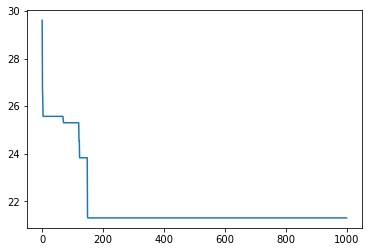

In [365]:
plt.plot(iter_list, likelihood_list)

In [40]:
def rw(max_it, verbose, P = np.identity(n)):   
    
    # initial value
    likelihood_P = get_likelihood(P)

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_iteration = [0]
    
    for i in tqdm(range(max_it)):   
        # sample next P
        P_prime = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P_prime = get_likelihood(P_prime)

        P, likelihood_P = P_prime, likelihood_P_prime

        # save best
        if likelihood_P < L_best:
            L_best = likelihood_P
            P_best = P

        results_likelihood.append(likelihood_P)
        results_iteration.append(i + 1)

    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, results_iteration, results_likelihood

In [25]:
P_0 = get_P_0(X)
# P_best, iter_list, likelihood_list = rw(1000, False, np.identity(n))
# plt.plot(iter_list, likelihood_list)
# plt.show()

# P_best, iter_list, likelihood_list = mcmc(1000, False, np.identity(n))
# plt.plot(iter_list, likelihood_list)
# plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 606.27it/s]

Best permutation:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Likelihood: 3.06.


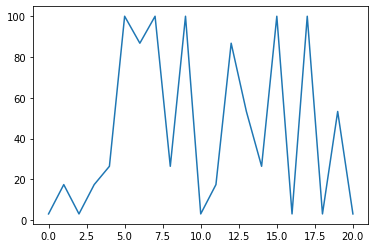

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 605.52it/s]


5
Best permutation:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Likelihood: 3.06.


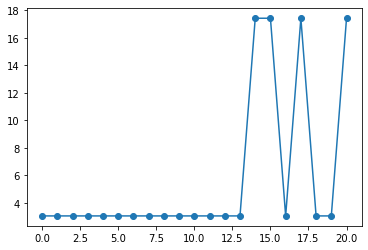

In [59]:
P_0 = get_P_0(X)

P_best, iter_list, likelihood_list = rw(20, False, P_0)
plt.plot(iter_list, likelihood_list)
plt.show()

P_best, iter_list, likelihood_list = mcmc(20, False, P_0, factor = 1.0)
plt.plot(iter_list, likelihood_list, 'o-')
plt.show()